In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import pandas as pd
import xarray as xr
import hvplot.xarray
import h5py
from astropy.time import Time
from scipy.interpolate import interp1d

pd.set_option('max_colwidth', 400)

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Load some of our own functions
* A `setup.py` is added to have easier access to our functions
* Under `overcast` root directory, run `pip install -e .` . 
* ***RESTART*** the kernel of this notebook, then you are good to go.


In [3]:
from overcast import readers as rd
from overcast.utils import fn2rgt, datainfo, query_rgt, box_sel

## Archive all the data we have a region
* Find all the files for each product
* put the RGT, cycle_number, and filename into Pandas DataFrame so we can match granules. This is done by calling `datainfo` in `utils.py`.

In [4]:
ROI = 'BEAUFORT' ## ['LAPTEV','CHUKCHI']
dataroot = Path.home()/'shared/data-overcast'/ROI

fns03 = sorted( (dataroot/'ATL03').glob('*.h5') )
fns07 = sorted( (dataroot/'ATL07').glob('*.h5') )
fns09 = sorted( (dataroot/'ATL09').glob('*.h5') )
db03 = datainfo(fns03)
db07 = datainfo(fns07)
db09 = datainfo(fns09)

## Select a granule and find the files from ATL07 and ATL09 database
* This uses a simple function `query_rgt` in `utils.py`

In [5]:
rgt = 1142; cyc = 3
fn03 = query_rgt(rgt,cyc,db03)[0]
fn07 = query_rgt(rgt,cyc,db07)[0]
fn09 = query_rgt(rgt,cyc,db09)[0]
print(fn03)
print(fn07)
print(fn09)

/home/jovyan/shared/data-overcast/BEAUFORT/ATL03/processed_ATL03_20190612011013_11420305_003_01.h5
/home/jovyan/shared/data-overcast/BEAUFORT/ATL07/processed_ATL07-01_20190612004407_11420301_003_02.h5
/home/jovyan/shared/data-overcast/BEAUFORT/ATL09/processed_ATL09_20190612004407_11420301_003_01.h5


## Check spacecraft orientation. 
* ATL09 is strong beam only so we have to find the matching ATL07 beam
* Choose the center beam for example

In [6]:
f07 = h5py.File(fn07, 'r')
#check to see if it is forward (1)  or backward (0) orientation to know which beam is strong/weak
print(f07['orbit_info/sc_orient'][0])
f07.close()

0


In [7]:
beam07 = 'gt2l'
beam09 = 'profile_2'

## Read ATL07 and ATL09 data
* For ATL07, the reader from the sea ice tutorial is used.
* A `getATL09` reader is added to `readers.py` but using xarray because we want to include some 2D data.
* Another advantage of xarray dataset is that now we can add attributes to variables.

In [8]:
with h5py.File(fn03,'r') as f03:
    epoch=f03['/ancillary_data/atlas_sdp_gps_epoch'][0]
    df03= rd.getATL03(f03,beam07)
    df03['time']=Time(epoch+df03['dt'],format='gps').utc.datetime

with h5py.File(fn07, 'r') as f07:
    epoch=f07['/ancillary_data/atlas_sdp_gps_epoch'][0]
    df07= rd.getATL07(f07,beam07)
    df07['time']=Time(epoch+df07['dt'],format='gps').utc.datetime
    
with h5py.File(fn09, 'r') as f09:
    epoch=f09['/ancillary_data/atlas_sdp_gps_epoch'][0]
    ds09= rd.getATL09(f09,beam09)
    if 'dt' in ds09.keys():
        ds09['time']=(['dt'],Time(epoch+ds09['dt'],format='gps').utc.datetime)    
    

## Select a region we want to plot
* Here we used the same bounding box as we used yesterday
* both ATL07 and ATL09 data are selected by calling the same function `box_sel` in `utils.py`. 
* Check `ds09_cut` and `df07_cut` to make sure they are in our box
* Correct ATL03 height to compare with ATL07

In [9]:
bbox = [-150,75,-110,78]
df03_cut=df03[box_sel(df03,bbox)]
df07_cut=df07[box_sel(df07,bbox)]
ds09_cut=ds09.where(box_sel(ds09,bbox),drop=True)

In [10]:
# mean sea surface correction
mss_corr=interp1d(df07.dt.values,df07.mss.values)
# inverted barometer correction
ib_corr=interp1d(df07.dt.values,df07.ib.values)
# ocean tide correction
ocean_corr=interp1d(df07.dt.values,df07.ocean.values)
# long period equilibrium tide correction
lpe_corr=interp1d(df07.dt.values,df07.lpe.values)

df03_cut['correction']=mss_corr(df03_cut.dt.values)+ib_corr(df03_cut.dt.values)+ocean_corr(df03_cut.dt.values)+lpe_corr(df03_cut.dt.values)
df03_cut['height_corr']=df03_cut.heights-df03_cut.correction


## Get the clout top and bottom height from ATL09
* This is a simple case, where only one layer of cloud is present
* At this time of year, no blowing snow either.

In [11]:
ROI = 'BEAUFORT'
dataroot = Path.home()/'shared/data-overcast'/ROI/'subset'
fns07 = sorted( (dataroot/'ATL07/gt2l').glob('*.nc') )
fns09 = sorted( (dataroot/'ATL09/profile_2').glob('*.nc') )



In [12]:
atl07 = xr.open_mfdataset(fns07)
atl07t = atl07.swap_dims({'dt':'Time'})
atl09 = xr.open_mfdataset(fns09)
atl09t = atl09.swap_dims({'dt':'Time'})

In [13]:
laytop = atl09t['layer_top'].values#[:,0]
laytop[laytop>20e3] = -100
ctopa = laytop.max(axis=1)
#ctop = laytop.min(axis=1)
laybot = atl09t['layer_bot'].values
cbota = laybot.min(axis=1)

In [14]:
laytop = ds09_cut['layer_top'].values
laytop[laytop>20e3] = -100
ctop = laytop.max(axis=1)
laybot = ds09_cut['layer_bot'].values
cbot = laybot.min(axis=1)

## Plot some ERA5 fields with the granule maps
* find the closest time from the hourly ERA5 data for convenience. 

In [15]:
erafn = Path.home()/'shared/data-overcast/ERA5/BEAUFORT_201906.nc'
dsera = xr.open_dataset(erafn)
dsera = dsera.rename({'lat':'lats','lon':'lons'})

In [16]:
tm07 = df07_cut['time'].mean()
tm09 = ds09_cut['time'].mean().values


In [17]:
#dsera_cut = dsera.where( box_sel(dsera,bbox,to_360=True) , drop=True)
#dsera_cut = dsera_cut.sel(time0=tm07.round('H'))
dsera_cut = dsera.sel(time0=tm07.round('H'))
dsera_cut = dsera_cut.sel(time1=tm07.round('H'))

## First plot in a map to see where the granule is 

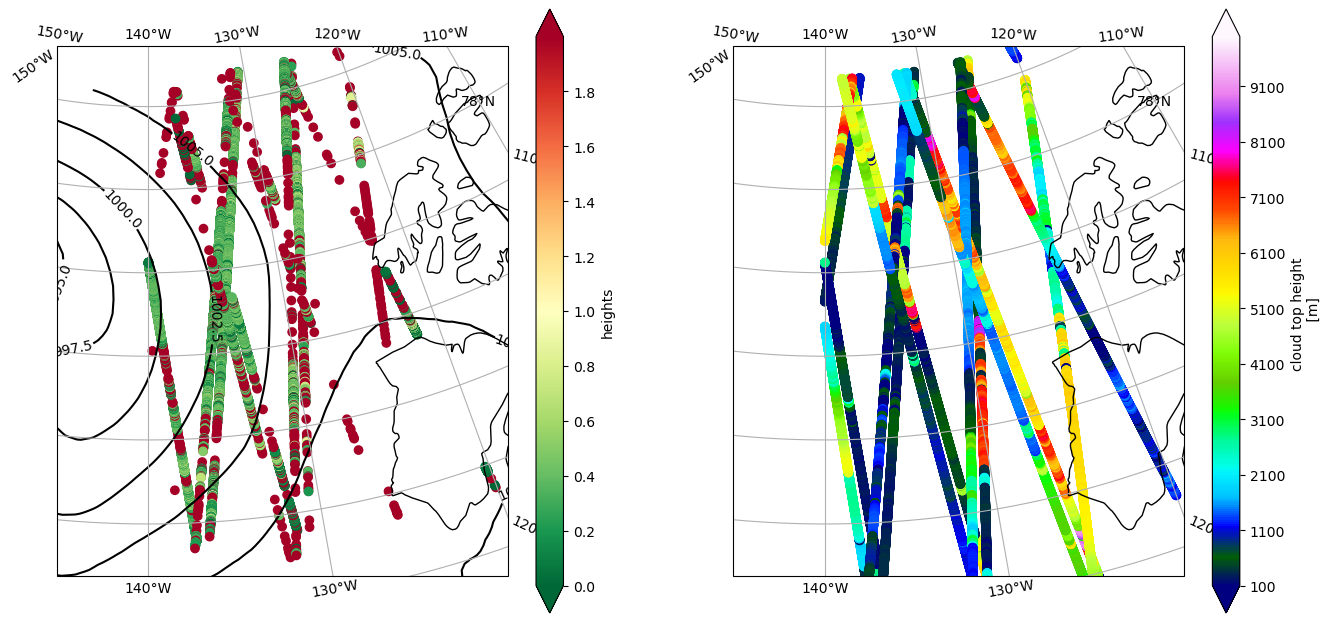

In [18]:
bbox = [-145,71,-120,80]
bea_proj = ccrs.NorthPolarStereo(central_longitude=-140)
pcproj   = ccrs.PlateCarree()

var = 'stype'
vmin = 0; vmax= 6
ticks=np.arange(vmin,vmax,1)

var = 'heights'
vmin = 0; vmax= 2
ticks=np.arange(vmin,vmax,.2)

fig = plt.figure(1,figsize=(16,8),dpi=100)
ax1 = fig.add_subplot(121,projection=bea_proj)
ax1.coastlines(resolution='50m', color='black', linewidth=1)
ax1.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], pcproj)
ax1.gridlines(draw_labels=True)
cs = ax1.contour(dsera_cut.lons,dsera_cut.lats,dsera_cut.slp/100,colors='k',transform=pcproj)
ax1.clabel(cs,cs.levels, inline=True,fontsize=10,fmt='%.1f')
hdl = plt.scatter(atl07t['lons'][::10], atl07t['lats'][::10],c=atl07t[var][::10], #s=3,
            cmap=plt.cm.get_cmap('RdYlGn').reversed(), 
            #cmap=plt.cm.get_cmap('gist_ncar_r').reversed(), 
            vmin=vmin,vmax=vmax,
            transform=pcproj)
plt.colorbar(label=var, shrink=1, ticks=ticks,extend='both');

ax2 = fig.add_subplot(122,projection=bea_proj)
ax2.coastlines(resolution='50m', color='black', linewidth=1)
ax2.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], ccrs.PlateCarree())
ax2.gridlines(draw_labels=True)
plt.scatter(atl09t['lons'], atl09t['lats'],c=ctopa, 
            cmap=plt.cm.get_cmap('gist_ncar_r').reversed(), 
            vmin=100,vmax=10000,
            transform=pcproj)
plt.colorbar(label='cloud top height \n [m]', shrink=1, ticks=np.arange(100,10000,1000),extend='both');

In [19]:
# bea_proj = ccrs.NorthPolarStereo(central_longitude=-140)
# pcproj   = ccrs.PlateCarree()

# var = 'heights'
# vmin = 0; vmax= 2
# ticks=np.arange(vmin,vmax,.2)
# fig = plt.figure(1,figsize=(8,8),dpi=100)
# ax1 = fig.add_subplot(211,projection=bea_proj)
# ax1.coastlines(resolution='50m', color='black', linewidth=1)
# ax1.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], pcproj)
# ax1.gridlines(draw_labels=True)
# cs = ax1.contour(dsera_cut.lons,dsera_cut.lats,dsera_cut.slp/100,colors='k',transform=pcproj)
# ax1.clabel(cs,cs.levels, inline=True,fontsize=10,fmt='%.1f')
# hdl = plt.scatter(df07_cut['lons'][::100], df07_cut['lats'][::100],c=df07_cut[var][::100], 
#             cmap=plt.cm.get_cmap('RdYlGn').reversed(), 
#             vmin=vmin,vmax=vmax,
#             transform=pcproj)
# plt.colorbar(label=var, shrink=1, ticks=ticks,extend='both');

# ax2 = fig.add_subplot(212,projection=bea_proj)
# ax2.coastlines(resolution='50m', color='black', linewidth=1)
# ax2.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], ccrs.PlateCarree())
# ax2.gridlines(draw_labels=True)
# plt.scatter(ds09_cut['lons'][::20], ds09_cut['lats'][::20],c=ctop[::20], 
#             cmap=plt.cm.get_cmap('gist_ncar_r').reversed(), 
#             vmin=100,vmax=1000,
#             transform=pcproj)
# plt.colorbar(label='cloud top height \n [m]', shrink=1, ticks=np.arange(100,1000,50),extend='both');

### plot MODIS and IS2 data with hvplot. 
* Modified from code by Friedrich Knuth, Michel, and Kyle. 

In [20]:
#plot MODIS and IS2 data with hvplot. Modified from code by Friedrich Knuth, Michel, and Kyle. 
import rasterio
import hvplot
import hvplot.xarray
import hvplot.pandas
from pyproj import Proj

In [21]:
dem_fn = '/home/jovyan/shared/data-overcast/modis/modis_output_test_GDALwarp.tif'
src = rasterio.open(dem_fn)
with xr.open_rasterio(src) as da:
    subplot_width  = int(src.shape[1] /9)
    subplot_height = int(src.shape[0] /10)

In [22]:
outProj = Proj(da.attrs['crs'])
x07,y07 = outProj(df07_cut.lons.values,df07_cut.lats.values)
df07_cut['x'] = x07
df07_cut['y'] = y07
x07a,y07a = outProj(atl07t.lons.values,atl07t.lats.values)
new_df = pd.DataFrame({'x':x07a[::100],'y':y07a[::100],'heights':atl07t.heights[::100]})
atl07t['x'] = x07a
atl07t['y'] = y07a

In [23]:
da_small = da.where( (da.band==1) & (da.x<-1e6) & (da.x>-2e6) & (da.y>-3e5) & (da.y<-1e5), drop=True )

In [24]:
# #%matplotlib inline
# da_small.hvplot.image(rasterize=True, 
#                         width=subplot_width,
#                         height=subplot_height,
#                       cmap='gray') * new_df.hvplot.scatter(x='x',y='y',c='stype')

In [25]:
da_small.hvplot.image(rasterize=True, 
                      width=1000,
                      height=400,
                      cmap='gray') * df07_cut.hvplot.scatter(x='x',y='y',c='stype')

:DynamicMap   [band]
   :Overlay
      .Image.I   :Image   [x,y]   (value)
      .Scatter.I :Scatter   [x]   (y,stype)

## Plot ATL07 and ATL09 data along the same latitude coordinate
* It seem the laser is totally attenuated near the right end of the plots so very little surface and column optical depth retrieval
* so it is likely cloud on the left and on the right are of different origin?

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

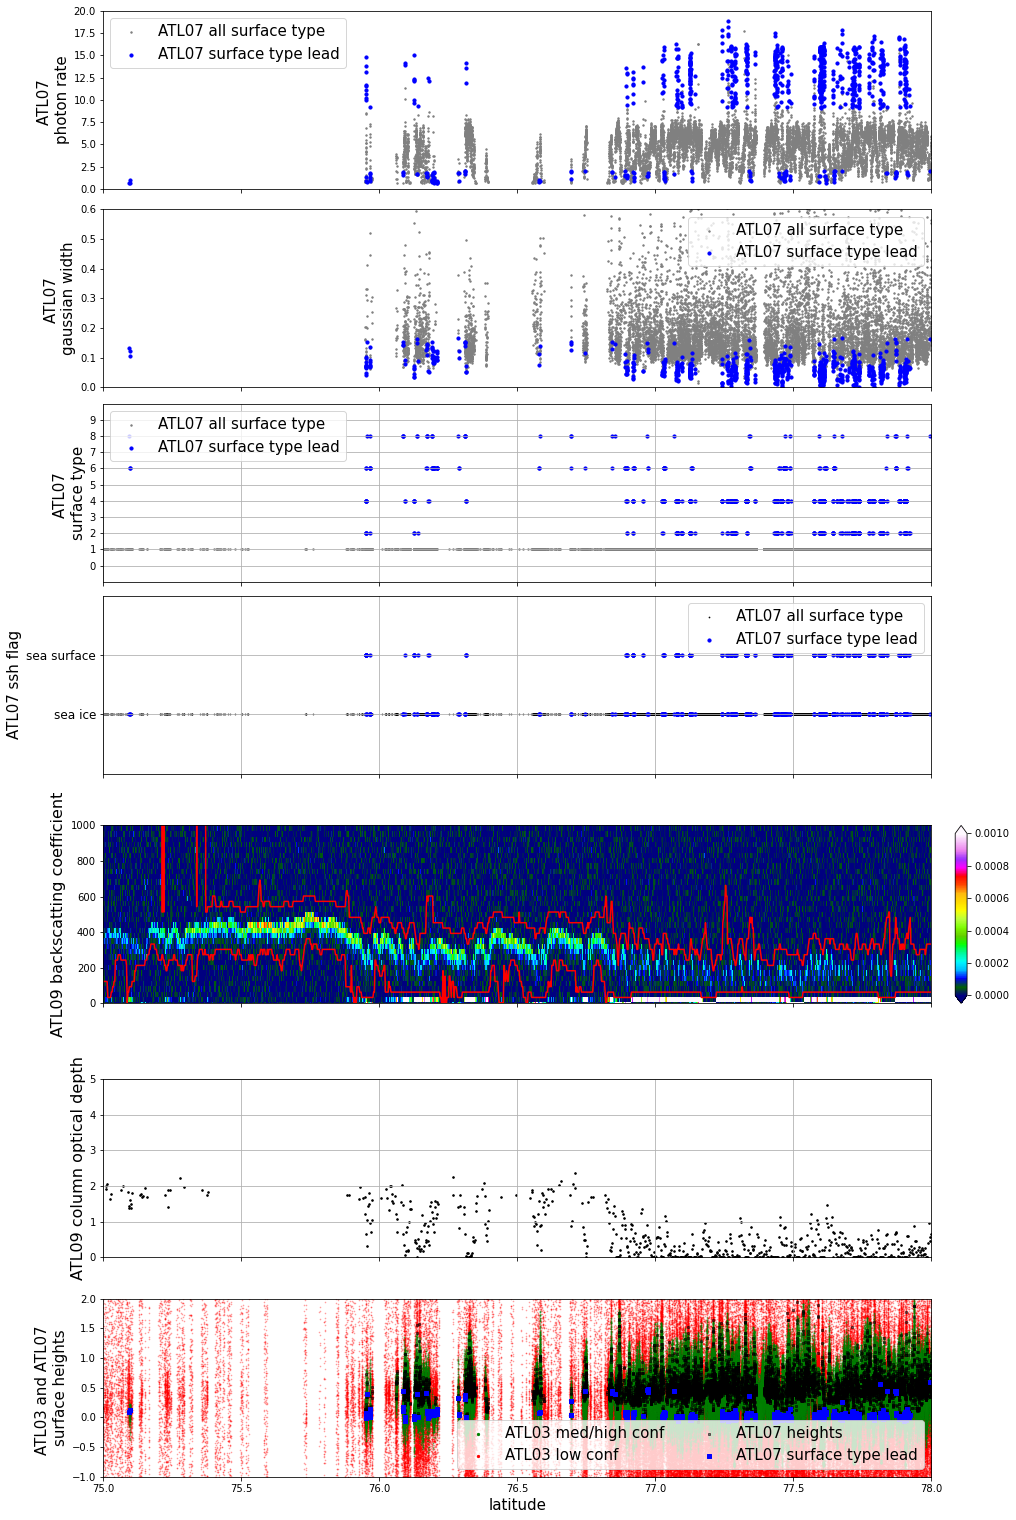

In [26]:
%matplotlib widget
fig,ax=plt.subplots(7,1,figsize=(14,21),sharex=True,constrained_layout=True)

i = 0
ax[i].scatter(df07_cut.lats,df07_cut.photon_rate,s=2,c='gray', label='ATL07 all surface type')
ax[i].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].photon_rate,s=10,c='b', label= 'ATL07 surface type lead')
ax[i].legend(fontsize=15)
ax[i].set_ylim(0,20)
ax[i].set_ylabel('ATL07 \nphoton rate',fontsize=15)

i+=1
ax[i].scatter(df07_cut.lats,df07_cut.gauss,s=2,c='gray', label='ATL07 all surface type')
ax[i].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].gauss,s=10,c='blue',label= 'ATL07 surface type lead')
ax[i].legend(loc=1,fontsize=15)
ax[i].set_ylabel('ATL07 \ngaussian width',fontsize=15)
ax[i].set_ylim(0,.6)

i+=1
ax[i].grid()
ax[i].scatter(df07_cut.lats,df07_cut.stype,s=2,c='gray',label='ATL07 all surface type')
ax[i].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].stype,s=10,c='blue',label= 'ATL07 surface type lead')
ax[i].legend(fontsize=15)
ax[i].set_ylim(-1,10)
ax[i].set_ylabel('ATL07 \nsurface type',fontsize=15)
ax[i].set_yticks(np.arange(0,10,1))

i+=1
ax[i].scatter(df07_cut.lats,df07_cut.ssh_flag,c='k',s=2,marker='.',label='ATL07 all surface type')
ax[i].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].ssh_flag,c='b',s=10,label='ATL07 surface type lead')
ax[i].legend(fontsize=15)
ax[i].grid()
ax[i].set_ylim(-1,2)
ax[i].set_yticks(np.arange(0,2,1))
ax[i].set_yticklabels(['sea ice', 'sea surface'],fontsize=12)
ax[i].set_ylabel('ATL07 ssh flag',fontsize=15)

i+=1
hdl = ax[i].pcolormesh(ds09_cut['lats'],ds09_cut['zbin'],ds09_cut['cab_prof'].T,
                      vmin=0,vmax=1e-3,
                      cmap=plt.cm.gist_ncar)
ax[i].set_ylim([0,1000])
cb = fig.colorbar(hdl, ax=ax[i],extend='both',aspect=10)
ax[i].plot(ds09_cut['lats'],ctop,'r')
ax[i].plot(ds09_cut['lats'],cbot,'r')
ax[i].set_ylabel('ATL09 backscatting coefficient',fontsize=16)

i+=1
ax[i].scatter(ds09_cut.lats,ds09_cut.column_od_asr,c='k',s=10,marker='.')
ax[i].set_ylabel('ATL09 column optical depth',fontsize=16)
ax[i].set_ylim([0,5])
ax[i].grid()

i+=1
#ax[i].scatter(df03_cut.lats,df03_cut.height_corr,c='b',s=.5,alpha=.3)
ax[i].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.height_corr[df03_cut.conf<3],c='r',s=.5,alpha=.3)
ax[i].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.height_corr[df03_cut.conf>2],c='g',s=.5,alpha=.3)
ax[i].scatter(0,0,c='g',s=5,alpha=1, label = 'ATL03 med/high conf')
ax[i].scatter(0,0,c='r',s=5,alpha=1, label= "ATL03 low conf")

ax[i].scatter(df07_cut.lats,df07_cut.heights,marker='s',s=5,c='k',alpha=.5, label= 'ATL07 heights')
ax[i].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].heights,marker='s',s=10,c='b', label= 'ATL07 surface type lead')
ax[i].legend(ncol=2, loc=4,fontsize=15)
ax[i].set_ylim(-1,2)
ax[i].set_ylabel('ATL03 and ATL07 \nsurface heights',fontsize=15)

ax[i].set_xlim(75,80)
ax[i].set_xlabel('latitude',fontsize=15)


for k in np.arange(0,7):
    ax[k].set_xlim([75,78])

In [27]:
## Failed attempt to use widget 
# bea_proj = ccrs.NorthPolarStereo(central_longitude=-140)
# pcproj   = ccrs.PlateCarree()

# var = 'heights'
# vmin = 0; vmax= 2
# ticks=np.arange(vmin,vmax,.2)
# fig = plt.figure(1,figsize=(8,8),dpi=100)
# ax1 = fig.add_subplot(211,projection=bea_proj)
# ax1.coastlines(resolution='50m', color='black', linewidth=1)
# ax1.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], pcproj)
# ax1.gridlines(draw_labels=True)
# plt.scatter(df07_cut['lons'][::100], df07_cut['lats'][::100],c=df07_cut[var][::100], 
#             cmap=plt.cm.get_cmap('RdYlGn').reversed(), 
#             vmin=vmin,vmax=vmax,
#             transform=pcproj)
# plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');

# laytop = ds09_cut['layer_top'].values
# laytop[laytop>20e3] = -100
# ctop = laytop.max(axis=1)
# ax2 = fig.add_subplot(212,sharex=ax1,sharey=ax1,projection=bea_proj)
# ax2.coastlines(resolution='50m', color='black', linewidth=1)
# ax2.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], ccrs.PlateCarree())
# ax2.gridlines(draw_labels=True)
# plt.scatter(ds09_cut['lons'][::20], ds09_cut['lats'][::20],c=ctop[::20], 
#             cmap=plt.cm.get_cmap('gist_ncar_r').reversed(), 
#             vmin=100,vmax=1000,
#             transform=pcproj)
# plt.colorbar(label='cloud top height', shrink=0.5, ticks=np.arange(100,1000,50),extend='both');